In [1]:
!pip install efficientnet -q
!pip install focal-loss -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Imports

In [2]:
import numpy as np
import pandas as pd

## Keras and Tf ##

import tensorflow as tf
import tensorflow.keras.callbacks as C
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.optimizers as O
import tensorflow.keras.utils as U
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.tfkeras as efn

#Utils

import random
import os
import math
import tqdm
import gc
import cv2
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate, CenterCrop, Cutout, Blur
)
from functools import partial
from numba import cuda
from skmultilearn.problem_transform import LabelPowerset
from sklearn.preprocessing import LabelBinarizer
gc.collect()


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(34)

In [4]:
FILE_PATH = "../input/ranzcr-clip-catheter-line-classification"

In [5]:
train = pd.read_csv(FILE_PATH + '/train.csv')

In [6]:
target_cols = [ 'ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']

# Config

In [7]:
DEVICE = "TPU"

In [8]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy

In [9]:
from kaggle_datasets import KaggleDatasets
COMPETITION_NAME = "ranzcr-clip-catheter-line-classification"
strategy = auto_select_accelerator()
BATCH_SIZE = strategy.num_replicas_in_sync * 16 if DEVICE == "TPU" else 8
REPLICAS = strategy.num_replicas_in_sync 
GCS_DS_PATH = KaggleDatasets().get_gcs_path(COMPETITION_NAME) if DEVICE == "TPU" else f"../input/ranzor-clip-resized-data-512-256"
FOLDS = 5
IMG_SIZES = (512, 512)
#Wether to only train a single fold or not (to avoid memory problems)
SINGLE_FOLD = False
if SINGLE_FOLD:
    FOLD = 0

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


# Images

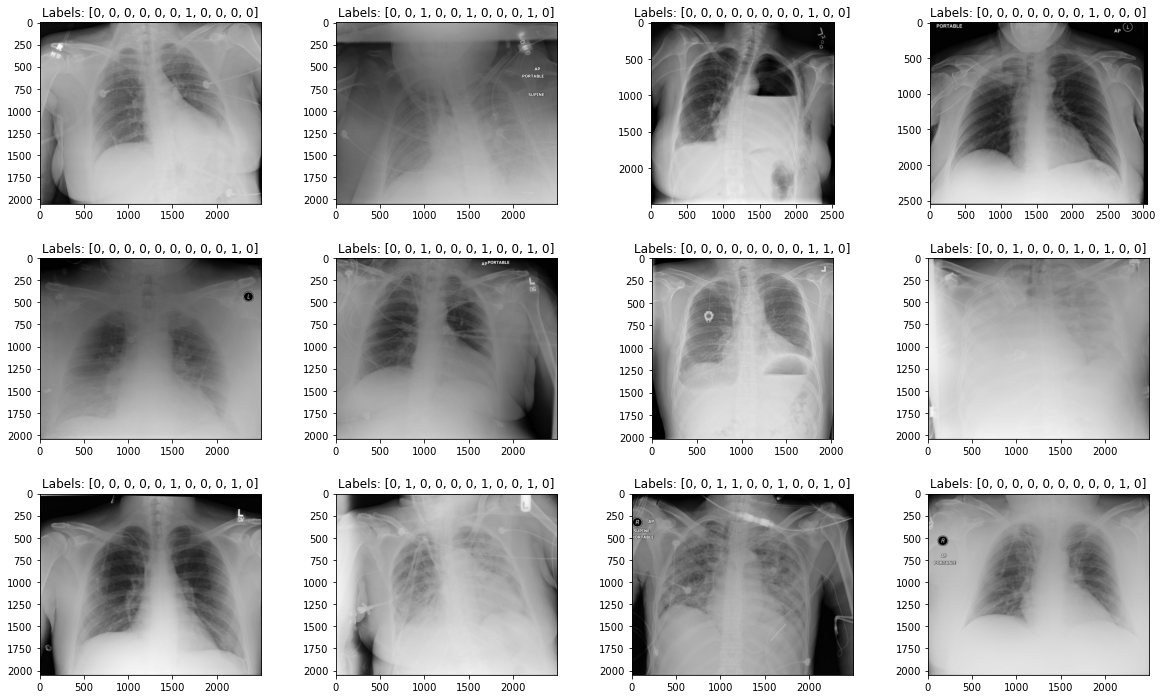

In [10]:
import matplotlib.image as immg
train_filepaths = (train['StudyInstanceUID'] + '.jpg').to_list()
train["StudyInstanceUIDFilePaths"] = train_filepaths
img_path = FILE_PATH + '/train'
fig = plt.figure(1,figsize=(20,12))
columns = 4
rows = 3
fea_num = 0
fea_cols = target_cols
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    img = immg.imread(img_path+'/'+train_filepaths[i])
    plt.imshow(img,cmap='gray')
    plt.title(f'Labels: {train.iloc[i][target_cols].to_list()}')
    fea_num+=1
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

# Data Augmentation

In [11]:
ROT_ = 10
SHR_ = 5
HZOOM_ = 5
WZOOM_ = 5
HSHIFT_ = 15
WSHIFT_ = 15

In [12]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=IMG_SIZES[0]):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [13]:
def build_decoder(with_labels=True, target_size=(300, 300), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = transform(img)
#         img = tf.numpy_function(func=aug_fn_albumentations, inp=[img, IMG_SIZES[0]], Tout=tf.float32)
#         img = tf.image.random_flip_left_right(img)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment

def set_shapes(with_labels = True):
    
    def _set_shapes(img, img_shape=(IMG_SIZES[0],IMG_SIZES[1],3)):
        img.set_shape(img_shape)
        return img
    
    def set_shapes_labels(img, label):
        img = _set_shapes(img)
        return img, label
    
    return set_shapes_labels if with_labels else _set_shapes

def aug_fn_albumentations(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img


def build_dataset(paths, labels=None, bsize=64, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    set_shapes_fn = set_shapes(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.map(set_shapes_fn, num_parallel_calls=AUTO)
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset


## Visualize Augmentated Images

In [14]:
paths = GCS_DS_PATH + "/train/" + train['StudyInstanceUID'] + '.jpg'
labels = train[target_cols]
decoder = build_decoder(with_labels=True, target_size=IMG_SIZES)
aug_dset = build_dataset(
        paths, labels = labels, bsize=BATCH_SIZE, decode_fn=decoder, cache_dir="",
        repeat=False, shuffle=False, augment=True
    )

In [15]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(16):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
#         ax.set_title(f"Label: {label[i]}")

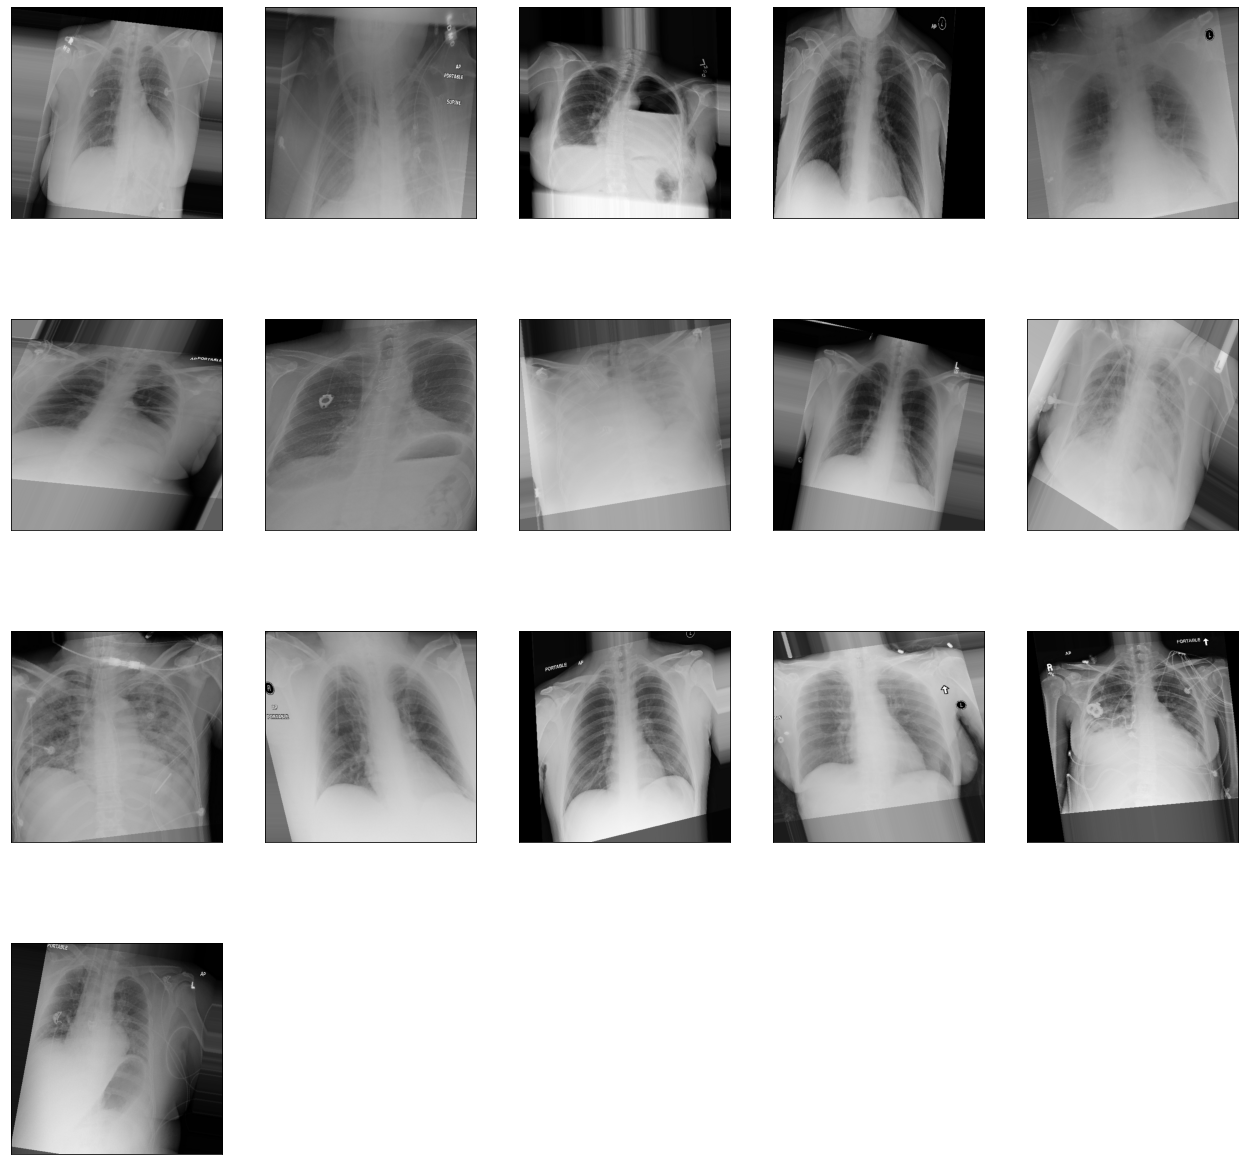

In [16]:
view_image(aug_dset)

# Training

In [17]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.00001
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 2
    lr_sus_ep  = 0
    lr_decay   = 0.85
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [18]:
base_model = efn.EfficientNetB5

In [19]:
import tensorflow_addons as tfa

In [20]:
from focal_loss import BinaryFocalLoss
def build_model(dim=331, base_model = base_model, n_labels=11,):
    inp = L.Input(shape=(dim,dim ,3))
    base = base_model(input_shape=(dim, dim,3),weights="imagenet", include_top=False)
    x = base(inp)
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dense(n_labels, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = "binary_crossentropy" 
    model.compile(optimizer=opt,loss=loss,metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True)])
    return model

In [21]:
from sklearn.model_selection import StratifiedKFold

train_targets = train[target_cols].values
kf = MultilabelStratifiedKFold(n_splits=FOLDS,random_state = 2020,shuffle = True)
oof = train[target_cols].copy()

for fold, (tr, te) in enumerate(kf.split(train, train_targets)):
    
    
#     if fold != FOLD:
#         continue
    
    print(f"TRAINING FOLD {fold}")
    
    #Assign Folds
    train_df = train.loc[tr, :]
    valid_df = train.loc[te, :]
    train_labels = train_df[target_cols]
    valid_labels = valid_df[target_cols]
    
    train_paths = GCS_DS_PATH + "/train/" + train_df['StudyInstanceUID'] + '.jpg'
    valid_paths = GCS_DS_PATH + "/train/" + valid_df['StudyInstanceUID'] + '.jpg'

    # Build the tensorflow datasets
    decoder = build_decoder(with_labels=True, target_size=IMG_SIZES)
    dtrain = build_dataset(
        train_paths, train_labels, bsize=BATCH_SIZE, decode_fn=decoder, cache_dir="",
    )

    dvalid = build_dataset(
        valid_paths, valid_labels, bsize=BATCH_SIZE, decode_fn=decoder, cache_dir="",
        repeat=False, shuffle=False, augment=False
    )

    #Callbacks
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'model{fold}.h5', save_best_only=True, monitor='val_auc', mode='max')
    
    
    #Build Model
    
    with strategy.scope():
        model = build_model(dim = 512, n_labels = 11)
    
    model.fit(
        dtrain,
        steps_per_epoch = train_paths.shape[0] // BATCH_SIZE,
        validation_data = dvalid, 
        validation_steps = valid_paths.shape[0] // BATCH_SIZE,
        epochs = 15, callbacks = [checkpoint, get_lr_callback(BATCH_SIZE)], verbose=1)
    model.load_weights(f"model{fold}.h5")
    
    
#     Predict on Validation Dataset
    oof.loc[te, :] = model.predict(dvalid, verbose=1)
    K.clear_session()
    gc.collect()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass shuffle=True, random_state=2020 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


TRAINING FOLD 0
115515392/115515256 [==============================] - 4s 0us/step
Epoch 1/15
187/187 [==============================] - 981s 5s/step - loss: 0.4839 - auc: 0.5240 - val_loss: 0.3528 - val_auc: 0.6338 - lr: 1.0000e-05
Epoch 2/15
187/187 [==============================] - 131s 698ms/step - loss: 0.2328 - auc: 0.7775 - val_loss: 0.2205 - val_auc: 0.8132 - lr: 6.4500e-04
Epoch 3/15
187/187 [==============================] - 131s 699ms/step - loss: 0.2062 - auc: 0.8379 - val_loss: 0.2075 - val_auc: 0.8716 - lr: 0.0013
Epoch 4/15
187/187 [==============================] - 131s 700ms/step - loss: 0.1790 - auc: 0.8870 - val_loss: 0.1691 - val_auc: 0.9105 - lr: 0.0011
Epoch 5/15
187/187 [==============================] - 131s 698ms/step - loss: 0.1624 - auc: 0.9141 - val_loss: 0.1669 - val_auc: 0.9245 - lr: 9.2508e-04
Epoch 6/15
187/187 [==============================] - 130s 698ms/step - loss: 0.1531 - auc: 0.9244 - val_loss: 0.1477 - val_auc: 0.9398 - lr: 7.8647e-04
Epoch 7/15

In [22]:
model.save_weights("ranzcr_focalloss_cvc.h5")

In [23]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
: